## This notebook takes the output of deepcell, processes it, segments cells, and outputs the extracted channel information

In [1]:
import numpy as np
import os
import skimage.io as io
import matplotlib.pyplot as plt
import sys
import pandas as pd

sys.path.append("../")

from segmentation.utils import data_utils, segmentation_utils
import xarray as xr

## This script is currently configured as a template to run with the provided example data. If running your own data, make a copy of this notebook first before modifying it. If you change this script you'll get merge conflicts when updating to the latest version. Go to file-> make a copy to create a copy of this notebook

In [2]:
# set up file paths
base_dir = "../data/example_dataset/"
deepcell_dir = os.path.join(base_dir, "deepcell_output")

In [3]:
# load the appropriate files
model_output = xr.load_dataarray(os.path.join(deepcell_dir, "deepcell_output.xr"))
input_xr = xr.load_dataarray(os.path.join(base_dir, "input_data", "Deepcell_Input.xr"))

### There are a few key tunable parameters for performing watershed

In [4]:
# this is the value that the deepcell probability mask is thresholded at to differentiate cell vs background.
# lower values will include more pixels, higher values less
interior_threshold = 0.35

# this is the amount that the image will be smoothed; more smoothing results in fewer splits but more merges
smooth = 8

# these are the channels that will plotted to assess segmentation accuracy; change to match your dataset
# channels within their own bracket will be plotted by themselves. Multiple channels will get plotted together
overlay_channels = [["HH3"], ["Membrane"], ["HH3", "Membrane"]]

# if you're doing whole-cell prediction, set this to None. If you're doing nuclear prediction, set a single value
nuclear_expansion=None

### We then segment the data

In [5]:
segmentation_dir = os.path.join(base_dir,
                                "segmentation_output_threshold_{}_smooth_{}_expansion_{}".format(interior_threshold,
                                                                                                 smooth,
                                                                                                 nuclear_expansion))
if not os.path.isdir(segmentation_dir):
    os.makedirs(segmentation_dir)

In [6]:
# watershed over the processed deepcell output
segmentation_utils.watershed_transform(model_output=model_output, channel_xr=input_xr, 
                                       overlay_channels=overlay_channels,
                                       output_dir=segmentation_dir,
                                       interior_threshold=interior_threshold,
                                       maxima_smooth=smooth, interior_smooth=smooth,
                                        nuclear_expansion=nuclear_expansion)

analyzing fov Point8


### We can then visualize the segmented mask generated by the watershed

In [7]:
# load segmentation generated by watershed
segmentation_labels = xr.load_dataarray(os.path.join(segmentation_dir,
                                                     "segmentation_labels.xr"))

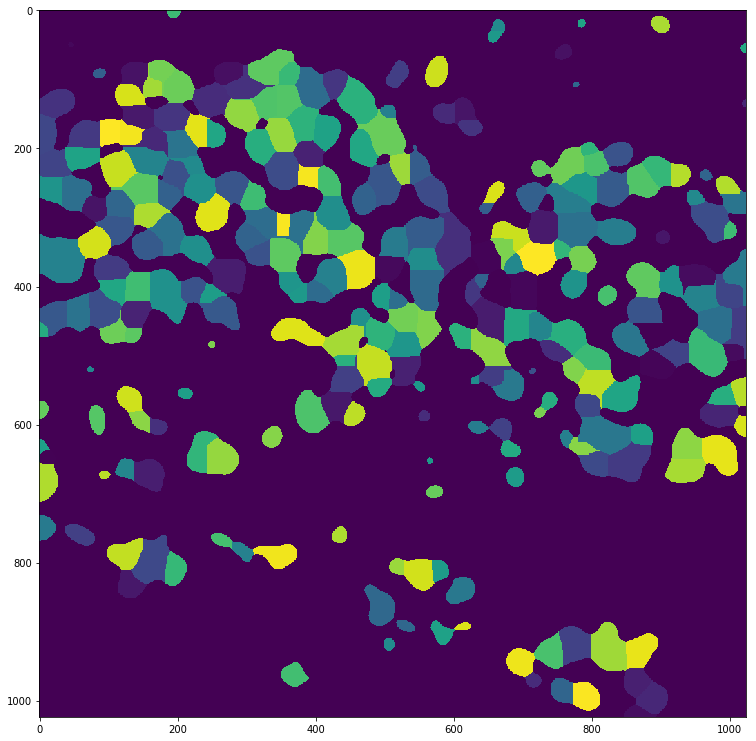

In [8]:
plt.figure(figsize = (13, 13))
plt.imshow(segmentation_labels.loc["Point8", :, :, "segmentation_label"])

### We can also visualize the segmented mask overlaid on the imaging data

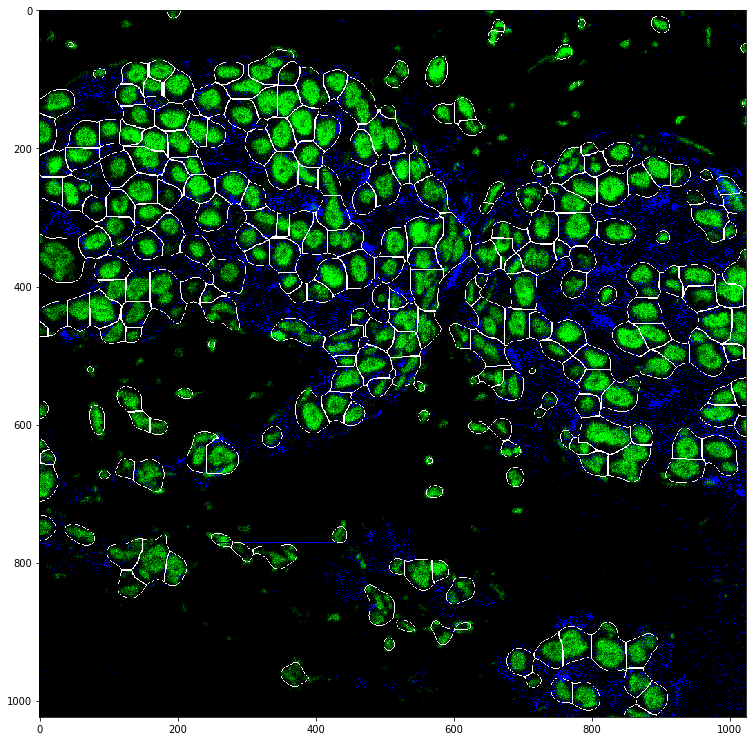

In [9]:
plt.figure(figsize = (13, 13))
plt.imshow(plt.imread(os.path.join(segmentation_dir, "Point8_HH3_Membrane_overlay.tiff")))

### Once you're happy with the segmentation parameters, we extract the data

In [10]:
# if loading your own dataset, make sure all imaging data is in the same folder, with each FOV given it's own folder
# All FOVs must have the same channels

# If the TIFs are in a subfolder, specify the name here
img_sub_folder = "TIFs"

# load channel data
points_folder = os.path.join(base_dir, "input_data")
points = os.listdir(points_folder)
points = [point for point in points if os.path.isdir(os.path.join(points_folder, point))
          and point.startswith("Point")]
points.sort()

single_cell_dir = base_dir + "single_cell_output_threshold_{}_smooth_{}_expansion_{}".format(interior_threshold, smooth, nuclear_expansion)

if not os.path.exists(single_cell_dir):
    os.makedirs(single_cell_dir)

In [11]:
# if loading more data than can fit into memory at once, we loop through in smaller increments
batch_size = 5
cohort_len = len(points)
num_batch = int(np.floor(cohort_len / batch_size))
combined_normalized_data = pd.DataFrame()
combined_transformed_data = pd.DataFrame()

for i in range(num_batch):
    current_points = points[i * batch_size:(i + 1) * batch_size]
    image_data = data_utils.load_imgs_from_dir(data_dir=points_folder, img_sub_folder=img_sub_folder, 
                                                      fovs=current_points)
    current_labels = segmentation_labels.loc[current_points, :, :, :]
    
    # segment the imaging data
    normalized_data, transformed_data = segmentation_utils.extract_single_cell_data(segmentation_labels=current_labels, image_data=image_data)
    
    combined_normalized_data = combined_normalized_data.append(normalized_data)
    combined_transformed_data = combined_transformed_data.append(transformed_data)
# if batch did not divide evenly into total, process remainder
if cohort_len % batch_size != 0:
    current_points = points[num_batch * batch_size:]
    image_data = data_utils.load_imgs_from_dir(data_dir=points_folder, img_sub_folder=img_sub_folder, fovs=current_points)
    current_labels = segmentation_labels.loc[current_points, :, :, :]
    
    # segment the imaging data
    normalized_data, transformed_data = segmentation_utils.extract_single_cell_data(segmentation_labels=current_labels, image_data=image_data)
    
    combined_normalized_data = combined_normalized_data.append(normalized_data)
    combined_transformed_data = combined_transformed_data.append(transformed_data)

extracting data from Point8


In [12]:
# save output as CSV
combined_normalized_data.to_csv(os.path.join(single_cell_dir, 'normalized_data.csv'), index=False)
combined_transformed_data.to_csv(os.path.join(single_cell_dir, 'transformed_data.csv'), index=False)
